# Transformers Hands On

If you're not already on Colab, you may click the following button (if 
you're not already on Colab): 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/charlesollion/dlexperiments/blob/master/5-Transformers-Intro/TransformersHandsOn.ipynb)
 
In order to run it on GPU, you may click Runtime > Change Runtime Type and select GPU as hardware accelerator.

This notebook is divided into two subparts: 
- **Building Blocks** understand the basic building block of a transformer, 
- **Pretrained** load a pretrained large model and see understand its dynamics.

## Building Blocks

#### Self-Attention

Given an input sequence $X$, produce 3 parametrized projections called Query $Q$, Key $K$, and Value $V$.



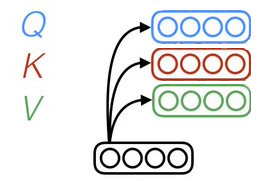

Let's define a sequence of vector inputs $X$:

In [ ]:
import torch

X = torch.normal(0, 1, size=(1, 3, 4))
# size = (Batch_size, sequence_length, input_dimension)
X.size()

In [ ]:
from torch import nn

dim = 4

query_layer = nn.Linear(dim, dim)
key_layer = nn.Linear(dim, dim)
value_layer = nn.Linear(dim, dim)

query = query_layer(X)
key = key_layer(X)
value = value_layer(X)

query.size(), key.size(), value.size()

Note that in Transformers we usually chose the projection dimension to be the same as the input vector, but this is not mandatory.

We then have the following formulae to compute the self-attention: 
$$SelfAttention(Q_i, \mathbf{K}, \mathbf{V}) = \sum_j softmax_j(\frac{Q_i \cdot \mathbf{K}^T}{\sqrt{d_k}}) V_j $$


In [ ]:
import math

attention_scores = torch.matmul(query, key.transpose(-1, -2))
attention_scores = attention_scores / math.sqrt(dim)

attention_probs = nn.Softmax(dim=-1)(attention_scores)
attention_probs

The attention probabilities is a tensor of shape `(batch_size, S, S)` where `S` is the length of the input (here 3). Read: for each element, with what strength is it "attending" to the others.
Finally we multiply the Value vectors of each element with these probabilites to get the final self-attention vectors.

In [ ]:
torch.matmul(attention_probs, value)

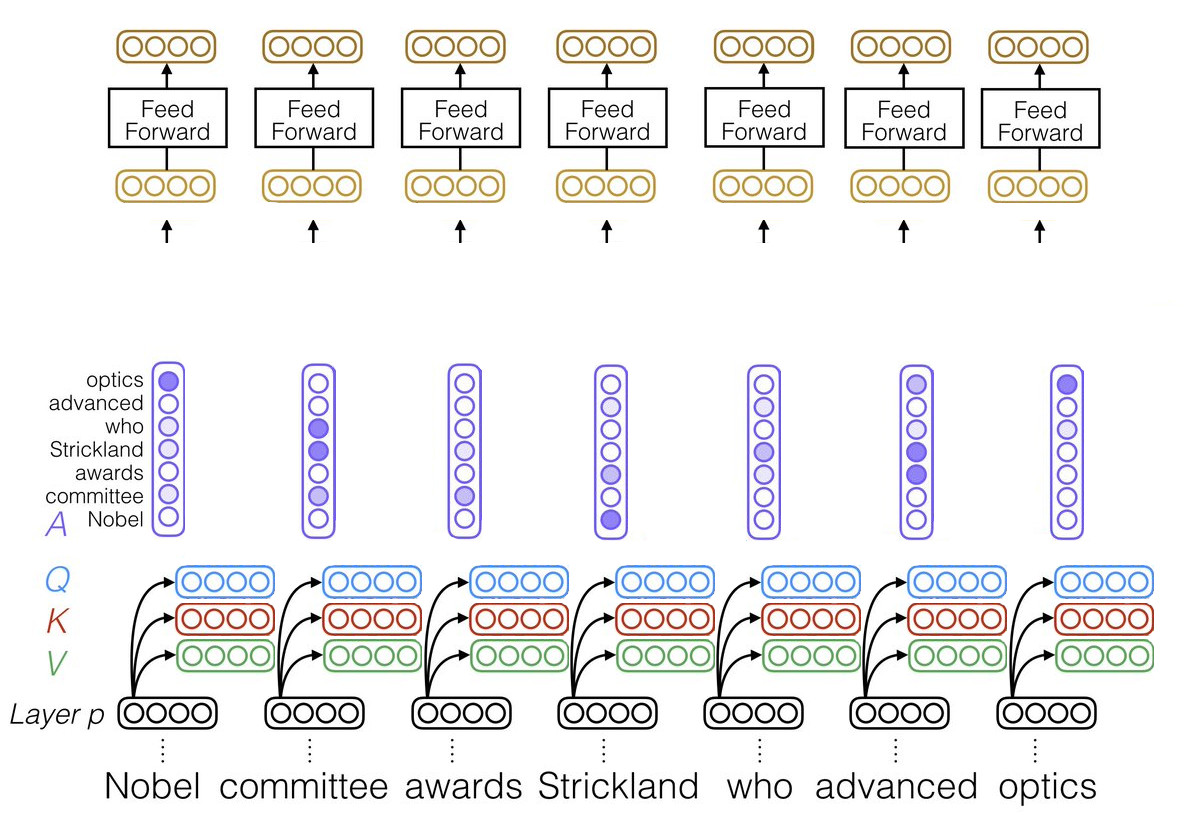

The following code (inspired by BERT) is a simple pytorch implementation of a single layer transformer, with a single head. A few implementation details have been omitted for clarity.

In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self, hidden_dim = 32):
        super().__init__()
        self.dim = hidden_dim
        self.query_layer = nn.Linear(self.dim, self.dim)
        self.key_layer = nn.Linear(self.dim, self.dim)
        self.value_layer = nn.Linear(self.dim, self.dim)
        self.output_layer = nn.Linear(self.dim, self.dim)
        self.dropout = nn.Dropout(0.2)
        self.LayerNorm = nn.LayerNorm(self.dim, eps=1e-4)

    def self_attention(self, X):
        query = self.query_layer(X)
        key = self.key_layer(X)
        value = self.value_layer(X)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.dim)
        
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        return torch.matmul(attention_probs, value)


    def forward(self, X):
        Z = self.self_attention(X)
        Z = self.output_layer(Z)
        Z = self.dropout(Z)
        Z = self.LayerNorm(Z + X)
        return Z

Remarks:
- The trainable parameters are in the 4 layers: key, value, query and output layer.
- There is a skip connection: we add the input to the output. This is similar to residual learning in the [Resnet paper](https://arxiv.org/abs/1512.03385).
- A normalization scheme is applied at the end of each layer: $y = \frac{x−E[x]}{ Var[x]+ϵ}∗γ+β$ where γ and β are new learnable parameters. It enables to stabilize the activation level for optimization purposes (better flow of gradients during SGD). Read the original [paper](https://arxiv.org/abs/1607.06450) for more details.
​
 

In [ ]:
T = SimpleTransformer(hidden_dim=4)

In [ ]:
T(X)

In standard transformers, there are multiple layers as such, and each layer has $N$ *attention heads*, which corresponds to $H$ heads $Q^h,K^h,V^h$ transformation matrices, and the outputs are concatenated before the last feed forward (output) layer.

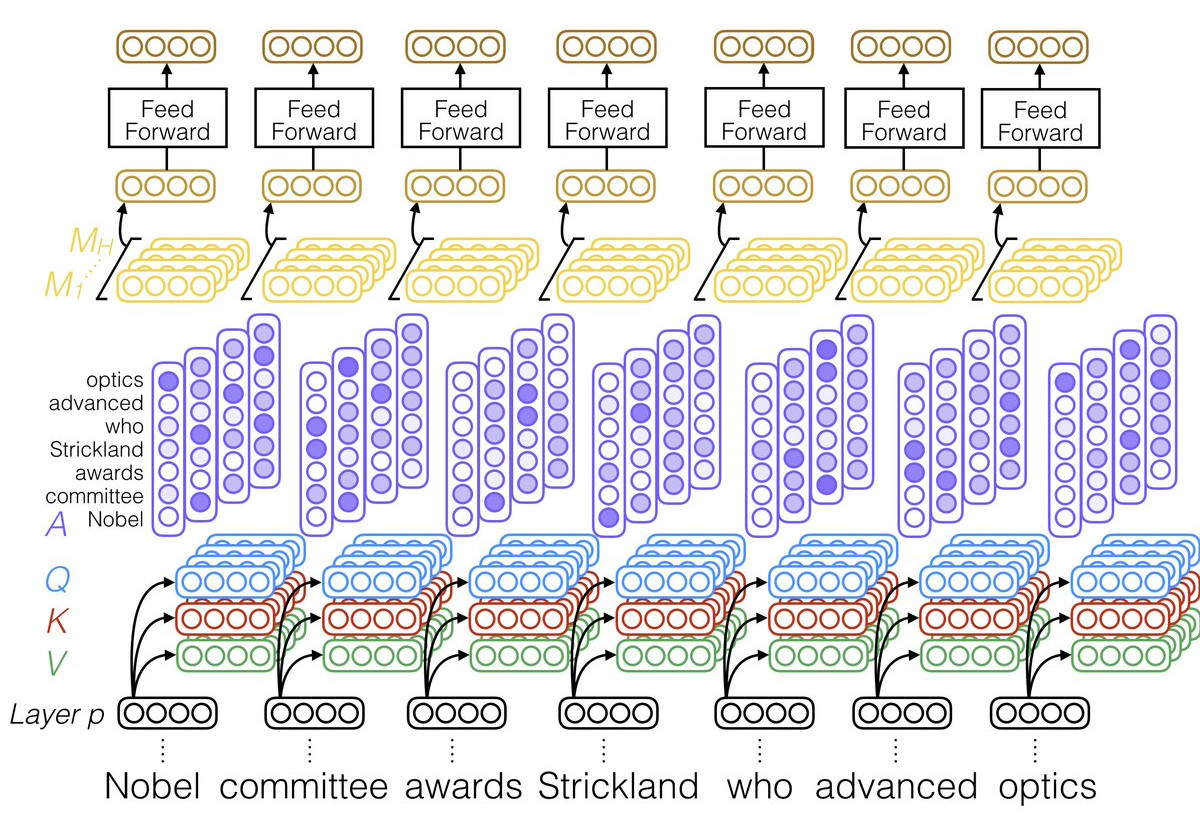

## Pretrained Transformers

Most of the time for natural language processing applications, we use a well-designed existing architecture instead of coding one. Besides the neural network architecture, we also use the pre-trained weights as they transfer well to downstream tasks. Here, the popular [Transformers library](https://huggingface.co/models) from HuggingFace is used.

In [ ]:
!pip install transformers
!pip install bertviz

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
# A GPT2 Language model is loaded
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)
# The corresponding tokenizer (splitting a text string into tokens in the GPT-2 vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
nb_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"number of trainable parameters in GPT-2 language model: {nb_params:,}")

In [ ]:
model

In [ ]:
text = "Building artificial intelligence tools requires a solid mathematical"
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
input_ids

In [ ]:
outputs = model(input_ids)

In [ ]:
inputs = tokenizer.encode(text, return_tensors='pt', add_special_tokens=True)
outputs = model(inputs, return_dict=True)

In [ ]:
logits = outputs.logits[0,-1].detach().cpu()
probas = torch.nn.functional.softmax(logits, dim=-1)
token_ids = logits.argsort()[-5:]

In [ ]:
print(text)
[tokenizer.decode(id)+f": ({probas[id]:.2f})" for id in token_ids][::-1]

Visualisation of attention weights in different attention heads, for different layers. Note that there are 12 layers,12 heads, and 8 tokens, so there are a lot of different attentions to visualize here !

In [ ]:
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [ ]:
from IPython.core.display import HTML
display(HTML('<script src="/static/components/requirejs/require.js"></script>'))
# Above two lines only needed when running in Colab

from bertviz import head_view
head_view(attention, tokens)